In [292]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from scipy.optimize import newton

Part (a):
The price of Bond A is: $ 0.9263030441650372
The price of Bond B is: $ 0.4754464918239323

Part (b):
The yield of Bond A is:  0.09213633958511538
The yield of Bond B is:  0.15530444677360591


C:\Users\nelli\AppData\Local\Temp\ipykernel_3288\2860227213.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


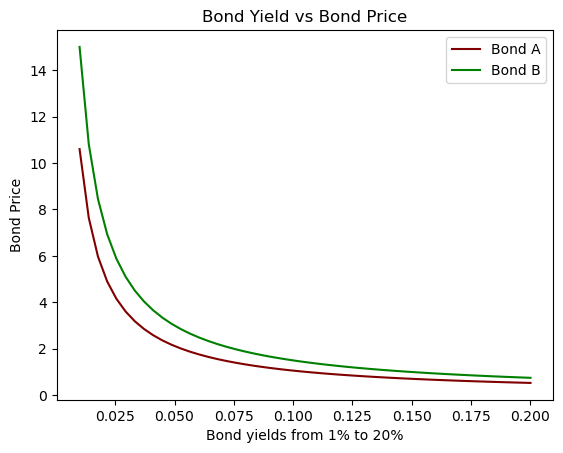

In [293]:
# 5. Bond Mechanics

# a) Price calc: Calculate the prices of bonds A and B

#Bootstrap function
def bootstrap(par_yields: 'np.ndarray', tenors: 'np.ndarray'):
    tenors_inter = np.linspace(0.5, tenors[-1], int(tenors[-1]) * 2) #Create equally spaced tenors
    coupon_rates_interp = np.interp(tenors_inter, tenors, par_yields) / 100 #Interpolate for coupon rates
    coupon_rates_interp = coupon_rates_interp * np.ones((len(coupon_rates_interp),len(coupon_rates_interp))) #Broadcast to size of coupon_rates_interp
    coupon_rates_interp = np.transpose(coupon_rates_interp) #Transpose to make rows have same value
    coupon_rates_interp = np.tril(coupon_rates_interp) #Create a lower triangular matrix
    np.fill_diagonal(coupon_rates_interp, coupon_rates_interp.diagonal() + 1) #Each diagonal should start with 1
    id = np.ones(len(coupon_rates_interp)) #The right hand side of Cz = id
    z = solve_triangular(coupon_rates_interp, id,lower=True) #Find z from Cz = id
    return z

#Define given numbers
tenors=np.array([0.5,1,2,3,5,7,10,20,30])
par_yields=np.array([3.5,4.2,4.7,4.8,5.6,7.2,7.4,7.8,8.0])
cA = 0.053 #5.3% semi-annually for Bond A
maturityA = 2
cB = 0.075 #7.5% semi-annually for Bond B
maturityB = 25
payment_timesA = np.linspace(start=1/2, stop=maturityA, num=maturityA*2)
payment_timesB = np.linspace(start=1/2, stop=maturityB, num=maturityB*2)
bootstrap_val = bootstrap(par_yields,tenors)

#Calculate price of bonds
def price(c,maturity):
    cfs = np.ones(maturity*2) * c / 2
    cfs[-1]+=1
    price = cfs @ bootstrap_val[:maturity*2]
    return price
priceA = price(cA,2)
priceB = price(cB,25)
print("Part (a):")
print("The price of Bond A is: $",priceA)
print("The price of Bond B is: $",priceB)

#Calculate yields
def yields(c,payment_times,maturity,price):
    cfs = np.ones(maturity*2) * c / 2
    cfs[-1]+=1
    f = lambda y: cfs @ np.exp(-y * payment_times) - price
    y = newton(f, bootstrap_val[maturity*2])
    return y
yieldA = yields(cA, payment_timesA, maturityA, priceA)
yieldB = yields(cB, payment_timesB, maturityB, priceB)
print("\nPart (b):")
print("The yield of Bond A is: ",yieldA)
print("The yield of Bond B is: ",yieldB)

#c) Price plot: Plot the prices of both bonds A and B calculated using yields ranging from to. What do you notice?
def price_from_yield(c,y):
    price = c*2 / y
    return price
yields = np.linspace(0.01,0.2,endpoint=True)
fig, ax = plt.subplots()
ax.plot(yields,price_from_yield(cA,yields), color="maroon", label="Bond A")
ax.plot(yields,price_from_yield(cB,yields), color="green", label = "Bond B")
ax.set_title("Bond Yield vs Bond Price")
ax.set_xlabel("Bond yields from 1% to 20%")
ax.set_ylabel("Bond Price")
ax.legend()
fig.show()

The monthly payment amount for this quote is: $ 1663.256237947953


Text(0, 0.5, 'Total payment amount')

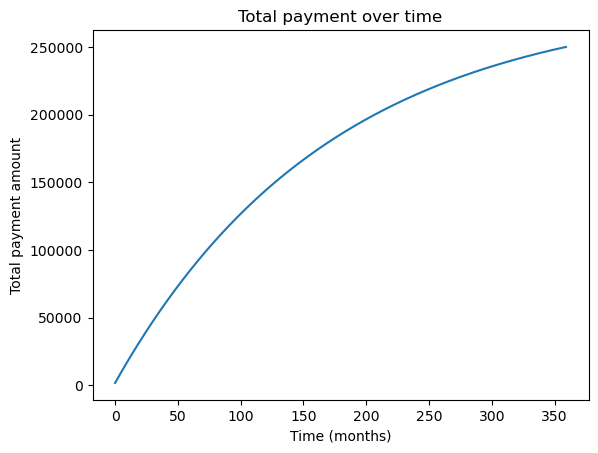

In [294]:
# 6. Mortgage implementation
# You’re in the process of purchasing a home and require a loan of L = 250,000

# a) Calc payment: The mortgage lender quotes an annual effective rate of i=7% for a 30 year loan. Calculate what your monthly payment amount would be given this quote.

L = 250000
i = 0.07 / 12 #interest rate divided into months
maturity = 30 #years
def mthly_mortgage(L,i,maturity):
    n = maturity * 12 #12 months in year
    v = 1 / (1+i)
    a = (1 - v**n) / i
    mthly = L / a
    return mthly
mthly = mthly_mortgage(L,i,maturity)

print("The monthly payment amount for this quote is: $",mthly)

# b) Plot interest and principal
#Using the recurrence relationships from the notes, plot the following:
def recurrence(L,i,maturity):
    Lk = np.zeros(maturity*12)
    for x in range(len(Lk)):
        if x==0:
            Lk[x] = L
        else:
            Lk[x] = Lk[x-1]*(1+i) - mthly_mortgage(L,i,maturity)
    return Lk
Lk = recurrence(L,i,maturity)
Lk = np.flip(Lk)

#The total payment amount in month k
fig, ax = plt.subplots()
ax.plot(range(360),Lk)
ax.set_title("Total payment over time")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Total payment amount")


Text(0, 0.5, 'Principal repaid')

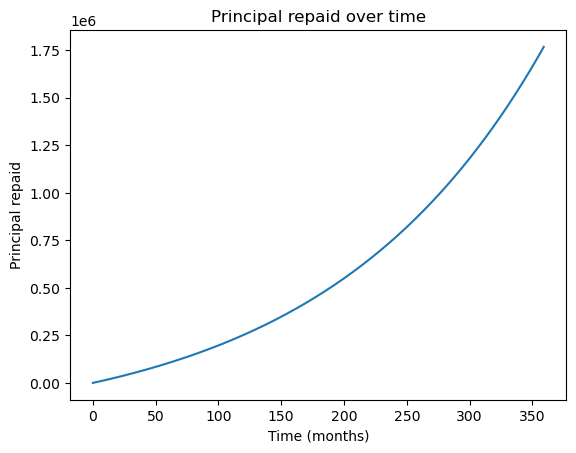

In [295]:
#The principal repaid in month
def principal_repaid(L,i,maturity):
    principal = np.zeros(maturity*12)
    principal[0] = L
    for x in range(1,len(principal)):
        principal[x] = principal[x-1]*i + principal[x-1]
    principal -= L
    return principal
principal = principal_repaid(L,i,maturity)
fig, ax = plt.subplots()
ax.plot(range(len(principal)),principal)
ax.set_title("Principal repaid over time")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Principal repaid")


Text(0, 0.5, 'Interest incurred')

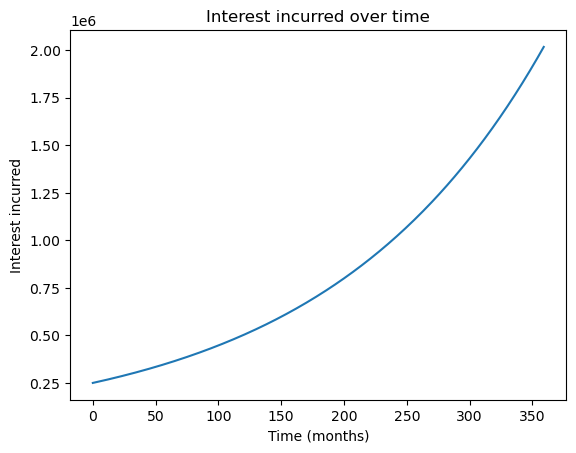

In [296]:
#The interest incurred in month k
def interest_incurred(L,i,maturity):
    interest = np.zeros(maturity*12)
    interest[0] = L
    for x in range(1,len(interest)):
        interest[x] = interest[x-1]*i + interest[x-1] #interest builds up
    return interest
interest = interest_incurred(L,i,maturity)
fig, ax = plt.subplots()
ax.plot(range(len(interest)),interest)
ax.set_title("Interest incurred over time")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Interest incurred")

The plot linearly increases.


Text(0, 0.5, 'Mortgage payment per month')

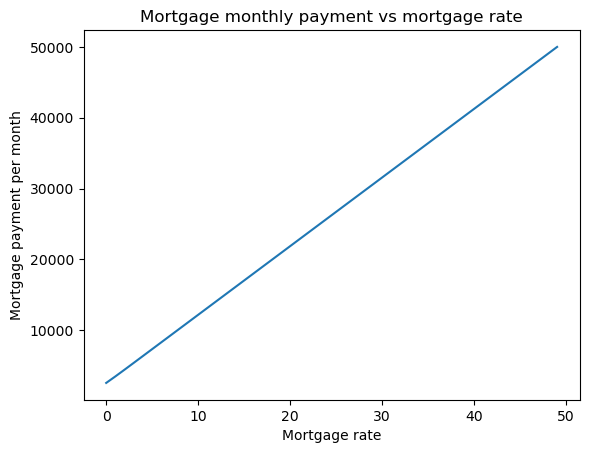

In [297]:
# c) Plot payment against rates
# Similarly to the bonds in part 5. plot the monthly payment amount against varying annual effective mortgage rates ranging from 1% to 20%. What do you notice?
i_arr = np.linspace(0.01,0.2,endpoint=True)
mthly_arr = mthly_mortgage(L,i_arr,maturity)
print("The plot linearly increases.")
fig, ax = plt.subplots()
ax.plot(range(len(mthly_arr)),mthly_arr)
ax.set_title("Mortgage monthly payment vs mortgage rate")
ax.set_xlabel("Mortgage rate")
ax.set_ylabel("Mortgage payment per month")